In [1]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib as mpl
import skimage
import tangram as tg
import pandas as pd

/Users/duleepa/anaconda3/envs/tangram-env/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/duleepa/anaconda3/envs/tangram-env/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [2]:
# Load data: adata_st as spatial data and adata_sc as single cell data

In [3]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [4]:
# Select genes to train the model

In [5]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

In [6]:
# Preprocess data using pp_adatas

In [7]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [8]:
# Deconvolution: Segmenting the cells on the corresponding histology

In [9]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

In [10]:
# Define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# Calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|                                                     | 0/324 [00:00<?, ?/s]/Users/duleepa/anaconda3/envs/tangram-env/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/duleepa/anaconda3/envs/tangram-env/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
100%|███████████████████████████████████████████| 324/324 [00:20<00:00, 15.46/s]


In [11]:
# Calculate cell counts in each spot

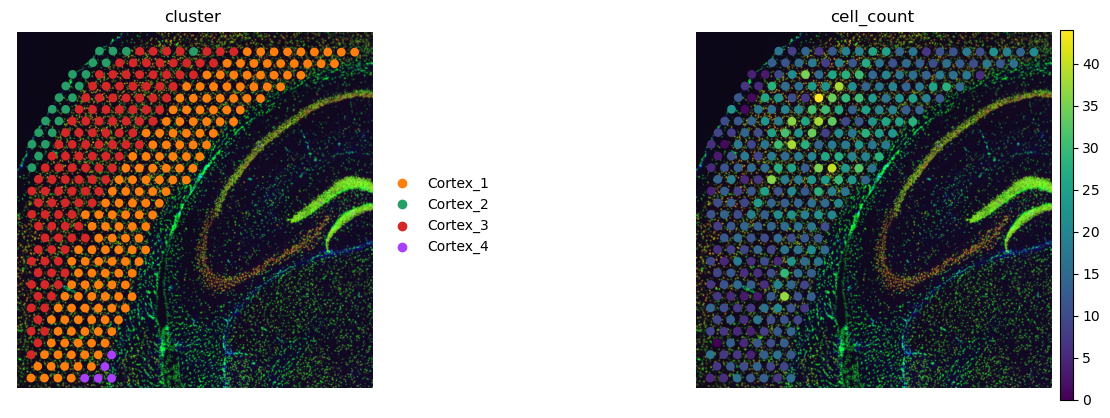

In [12]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

In [13]:
# Deconvolution via alignment

In [14]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
#     device="cuda:0",
    device='cpu',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and customized density_prior in constrained mode...


Score: 0.613, KL reg: 0.125, Count reg: 5754.427, Lambda f reg: 4474.604
Score: 0.699, KL reg: 0.012, Count reg: 4.608, Lambda f reg: 728.805
Score: 0.701, KL reg: 0.012, Count reg: 2.458, Lambda f reg: 249.356
Score: 0.702, KL reg: 0.012, Count reg: 0.844, Lambda f reg: 170.564
Score: 0.702, KL reg: 0.012, Count reg: 1.372, Lambda f reg: 142.565
Score: 0.702, KL reg: 0.012, Count reg: 1.138, Lambda f reg: 128.114
Score: 0.702, KL reg: 0.012, Count reg: 1.307, Lambda f reg: 114.627
Score: 0.702, KL reg: 0.012, Count reg: 0.862, Lambda f reg: 104.574
Score: 0.702, KL reg: 0.012, Count reg: 0.459, Lambda f reg: 92.502
Score: 0.702, KL reg: 0.012, Count reg: 0.904, Lambda f reg: 87.906


INFO:root:Saving results..


In [15]:
# Export the mapping between spot ID and segmentation ID

In [16]:
tg.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"].head()

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


,spot_idx,y,x,centroids
0,AAATGGCATGTCTTGT-1,5304.000000,731.000000,AAATGGCATGTCTTGT-1_0
1,AAATGGCATGTCTTGT-1,5320.947519,721.331554,AAATGGCATGTCTTGT-1_1
2,AAATGGCATGTCTTGT-1,5332.942342,717.447904,AAATGGCATGTCTTGT-1_2
3,AAATGGCATGTCTTGT-1,5349.584558,558.089490,AAATGGCATGTCTTGT-1_3
4,AAATGGCATGTCTTGT-1,5342.385687,566.886874,AAATGGCATGTCTTGT-1_4


In [17]:
# Deconvolution results

In [18]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
adata_st.obsm["tangram_ct_count"].head()

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


,x,y,cell_n,centroids,Pvalb,L4,Vip,L2/3 IT,Lamp5,NP,...,L5 PT,Astro,L6b,Endo,Peri,Meis2,Macrophage,CR,VLMC,SMC
AAATGGCATGTCTTGT-1,641,5393,13,"[AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...",1,0,0,0,2,1,...,3,1,0,0,0,0,0,0,0,0
AACAACTGGTAGTTGC-1,4208,1672,15,"[AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...",2,0,2,0,2,0,...,2,0,0,0,0,0,0,0,0,0
AACAGGAAATCGAATA-1,1117,5117,28,"[AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...",2,0,4,0,1,1,...,0,1,0,0,0,0,0,0,0,0
AACCCAGAGACGGAGA-1,1101,1274,5,"[AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...",2,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
AACCGTTGTGTTTGCT-1,399,4708,7,"[AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...",2,1,0,1,2,0,...,0,0,0,2,0,0,0,0,0,0
